# Introduction

Here, we compare analytic results for volume estimation, with the numeric results from using circular and random vector perturbations. We want to confirm the results are identical.

### Base

Loss landscape and model definition. (Not initialization)

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from typing import List

class LossLandscape:
    def __init__(self, 
                 minima_sharp_loc=-1.0, 
                 minima_wide_loc=1.0,
                 sharp_width=0.1,
                 wide_width=0.2,
                 amplitude=1.0,
                 baseline=1.0):
        """
        Initialize a customizable loss landscape with two minima.
        """
        self.minima_sharp_loc = minima_sharp_loc
        self.minima_wide_loc = minima_wide_loc
        self.sharp_width = sharp_width
        self.wide_width = wide_width
        self.amplitude = amplitude
        self.baseline = baseline
        
    def get_minima_parameters(self):
        """Return the key parameters defining the minima"""
        return {
            'minima_sharp_loc': self.minima_sharp_loc,
            'minima_wide_loc': self.minima_wide_loc,
            'sharp_width': self.sharp_width,
            'wide_width': self.wide_width
        }
        
    def __call__(self, x):
        """Compute the loss at point(s) x"""
        gaussian_sharp = self.amplitude * torch.exp(
            -0.5 * ((x - self.minima_sharp_loc) / self.sharp_width)**2
        )
        gaussian_wide = self.amplitude * torch.exp(
            -0.5 * ((x - self.minima_wide_loc) / self.wide_width)**2
        )
        return self.baseline - gaussian_sharp - gaussian_wide
    
    def visualize(self, x_range=(-2, 2), num_points=500):
        """Visualize the loss landscape"""
        x = torch.linspace(x_range[0], x_range[1], num_points)
        loss = self(x)
        
        plt.figure(figsize=(8, 5))
        plt.plot(x.numpy(), loss.numpy())
        plt.xlabel('x')
        plt.ylabel('Loss')
        plt.title('Loss Landscape')
        
        plt.axvline(x=self.minima_sharp_loc, color='r', 
                   linestyle='--', alpha=0.3, label='Sharp minimum')
        plt.axvline(x=self.minima_wide_loc, color='b', 
                   linestyle='--', alpha=0.3, label='Wide minimum')
        
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()

    def random_parameter_search(self, dim: int, num_samples: int = 10000, upper = 10, low = -10):
        """
        Perform random parameter search using the class's minima parameters
        
        Args:
            dim: Dimension of parameter space
            num_samples: Number of random samples to generate
            
        Returns:
            Tuple of (sharp_count, wide_count, samples)
        """
        minima_sharp_count = 0
        minima_wide_count = 0
        samples = []
        
        for _ in range(num_samples):
            params = np.random.uniform(low=low, high=upper, size=dim)
            product = np.prod(params)
            samples.append(product)
            
            if abs(product - self.minima_sharp_loc) < self.sharp_width:
                minima_sharp_count += 1
            if abs(product - self.minima_wide_loc) < self.wide_width:
                minima_wide_count += 1
        
        return minima_sharp_count, minima_wide_count, samples
        
class NParameterModel(torch.nn.Module):
    def __init__(self, initial_values: List[float]):
        super().__init__()
        # Create N parameters from the initial values
        self.params = torch.nn.ParameterList([
            torch.nn.Parameter(torch.tensor([val], dtype=torch.float32))
            for val in initial_values
        ])
    
    def forward(self):
        # Compute product of all parameters
        x = torch.prod(torch.stack([p for p in self.params]))
        return x

    def get_parameter_values(self):
        return [p.item() for p in self.params]

### Perturbation Functions

We import our perturbation functions.

In [2]:
# Importing our existing funcs
import os
import sys
from pathlib import Path
# Add parent directory to sys.path
parent_dir = Path.cwd().parent.parent
sys.path.append(str(parent_dir))
parent_dir = Path.cwd().parent
sys.path.append(str(parent_dir))
# Import modules
from perturb_simple import (
    generate_random_perturbations,
    wiggle_multiple_directions,
    loss_threshold_crossing,
)

from visualize_2d import (
    plot_parameter_space_with_arrows,
    plot_parameter_space_with_polygon,
)

## In our case, we might also use a generate circular perturbations a lot
def generate_circular_perturbations(num_vectors):
    """
    Generate evenly spaced unit vectors around a circle using only PyTorch.
    """
    angles = torch.linspace(0, 2 * torch.pi, num_vectors + 1)[:-1]  # Evenly spaced, exclude duplicate 2π
    x = torch.cos(angles)
    y = torch.sin(angles)
    
    return [
        {'params.0': x[i].reshape(1), 'params.1': y[i].reshape(1)} 
        for i in range(num_vectors)
    ]

### Calculation Methods

We have circular and random perturbations, and for the actual radius calculation we consider a pair of methods - the exact analytical radii, and the numeric radii from our coefficient based approach. The numeric method is in loss_threshold_crossing, while the analytic function is here

In [3]:
# This is code that determines the exact distance from the source point to the edges of the curves
def find_r(x, y, a, w, vx, vy):
    """
    Compute the smallest positive r such that (x + r*vx, y + r*vy)
    intersects either curve y = (a ± w)/x.
    """
    def solve_quadratic(A, B, C):
        # Handle near-zero A (linear case)
        if abs(A) < 1e-12:
            if abs(B) < 1e-12:
                return None
            r = -C / B
            return r if r > 0 else None

        D = B**2 - 4 * A * C
        if D < 0:
            return None

        sqrt_D = np.sqrt(D)
        r1 = (-B + sqrt_D) / (2 * A)
        r2 = (-B - sqrt_D) / (2 * A)

        positive_roots = [r for r in (r1, r2) if r > 0]
        return min(positive_roots) if positive_roots else None

    # Try both boundaries: a + w and a - w
    r_candidates = []
    for delta in [+w, -w]:
        A = vx * vy
        B = x * vy + y * vx
        C = x * y - (a + delta)

        r = solve_quadratic(A, B, C)
        if r is not None:
            r_candidates.append(r)

    return min(r_candidates) if r_candidates else None

# A wrapper that processes a list of perturbation vectors
def compute_r_list(origin, a, w, perturb_vectors):
    x, y = origin
    r_list = []

    for vec in perturb_vectors:
        vx = vec['params.0'].item()
        vy = vec['params.1'].item()
        r = find_r(x, y, a, w, vx, vy)
        r_list.append(r)

    return r_list

## Analytical Volume

The analytical volume derived from our formulas is

$$
\begin{split}
V &= 2\sqrt{2w (a + w)} + 2w \log \frac{\left(1 + \sqrt{\frac{w}{a+w}} \right)}{\left(1 - \sqrt{\frac{w}{a+w}} \right)} - (a - w)\log \frac{\left(1 + \sqrt{\frac{2w}{a + w}} \right)}{\left(1 - \sqrt{\frac{2w}{a + w}} \right)}
\end{split}
$$

where the upper and lower bounds of our loss are given by $(x, \frac{a \pm w}{x})$. Note that the velocity from our monte carlo method is

$$
V = V_{\text{unit ball, n}} \int r^n (\theta) d\theta
$$

For $n = 2$, the volume of the unit ball is $\pi$. Our methods compute the expected value of $r^n$, so we divide our analytic volume by $\pi$ to have their results match (in theory).

In [4]:
def analytic_volume(a, w):
    # First term: 2 * sqrt(2 * w * (a + w))
    term1 = 2 * np.sqrt(2 * w * (a + w))
    
    # Second term: 2w * log[(1 + sqrt(w/(a+w))) / (1 - sqrt(w/(a+w)))]
    sqrt_w_over_aw = np.sqrt(w / (a + w))
    numerator = 1 + sqrt_w_over_aw
    denominator = 1 - sqrt_w_over_aw
    term2 = 2 * w * np.log(numerator / denominator)
    
    # Third term: (a - w) * log[(1 + sqrt(2w/(a+w))) / (1 - sqrt(2w/(a+w)))]
    sqrt_2w_over_aw = np.sqrt(2 * w / (a + w))
    numerator = 1 + sqrt_2w_over_aw
    denominator = 1 - sqrt_2w_over_aw
    term3 = (a - w) * np.log(numerator / denominator)
    
    # Combine all terms
    V = term1 + term2 - term3
    
    return V

# Example usage:
a = 1.0
w = 0.2
volume = analytic_volume(a, w)
print(f"The computed volume is: {volume}")

The computed volume is: 0.6788802191114742


## Saving, Loading, Subset Volume

Functions for saving the radii data, loading it, and computing the volume associated with a subset

In [5]:
import random

def save_r_arrays_np(folder_path,
                    filename,
                    circle_r_array, 
                    random_r_array, 
                    exact_circle_r_array, 
                    exact_random_r_array):
    """
    Save r_arrays as a compressed NumPy .npz file.
    """
    os.makedirs(folder_path, exist_ok=True)
    
    np.savez_compressed(
        os.path.join(folder_path, filename),
        circle_r_array=np.array(circle_r_array, dtype=object),
        random_r_array=np.array(random_r_array, dtype=object),
        exact_circle_r_array=np.array(exact_circle_r_array, dtype=object),
        exact_random_r_array=np.array(exact_random_r_array, dtype=object)
    )
    
    print(f"Data saved to: {os.path.join(folder_path, filename)}")

def load_r_arrays_np(filepath):
    """
    Load saved r_arrays and return them exactly as stored (in lists).
    Returns: (circle_r, random_r, exact_circle_r, exact_random_r) as lists
    """
    data = np.load(filepath, allow_pickle=True)
    
    # Convert each array back to list (preserving original structure)
    def to_list(arr):
        if arr.ndim == 0:  # scalar case
            return arr.item()
        return [to_list(x) if isinstance(x, np.ndarray) else x for x in arr]
    
    return (
        to_list(data['circle_r_array']),
        to_list(data['random_r_array']),
        to_list(data['exact_circle_r_array']),
        to_list(data['exact_random_r_array'])
    )

def save_perturbation_vectors(folder_path, circle_vectors, random_vectors):
    """Save perturbation vectors to an organized folder structure."""
    # Save both sets of vectors
    np.savez_compressed(
        os.path.join(folder_path, "perturbation_vectors.npz"),
        circle_perturb_vectors=circle_vectors,
        random_perturb_vectors=random_vectors,
    )
    print(f"Saved perturbation vectors to {folder_path}/perturbation_vectors.npz")
    
def compute_sampled_volume(r_values, K, dimension):
    # Select K random elements (without replacement)
    sampled_r = random.sample(r_values, K)
    rn_values = [r ** dimension for r in sampled_r]
    volume = sum(rn_values) / len(rn_values)
    return volume

def compute_all_volumes(circle_r_array, random_r_array, 
                       exact_circle_r_array, exact_random_r_array, 
                       k, dimension=2):
    """
    Compute volumes for all models using sampled r-values.
    
    Args:
        arrays: lists of r values
        k: Number of samples to use for volume computation
        dimension: Dimension for volume calculation (default=2)
        
    Returns:
        Tuple of four volume lists: (vol_circle, vol_random, vol_circle_exact, vol_random_exact)
    """
    vol_circle, vol_random = [], []
    vol_circle_exact, vol_random_exact = [], []
    
    for model_idx in range(len(circle_r_array)):
        # Use min(k, len(array)) to handle cases where k > available samples
        n_samples = min(k, len(circle_r_array[model_idx]))
        
        vol_circle.append(compute_sampled_volume(circle_r_array[model_idx], n_samples, dimension))
        vol_random.append(compute_sampled_volume(random_r_array[model_idx], n_samples, dimension))
        vol_circle_exact.append(compute_sampled_volume(exact_circle_r_array[model_idx], n_samples, dimension))
        vol_random_exact.append(compute_sampled_volume(exact_random_r_array[model_idx], n_samples, dimension))
    
    return vol_circle, vol_random, vol_circle_exact, vol_random_exact

# Filter Normalization

Filter normalization function.

In [6]:
def filtnorm(named_parameters):
    """
    Return filter norms as a dictionary.
    
    Args:
        named_parameters: Iterator of (name, parameter) tuples (from model.named_parameters())
    Returns:
        Dictionary {param_name: norm_tensor} or list of norm tensors (maintaining original order)
    """
    norm_dict = {}
    
    for name, param in named_parameters:
        param = param.detach()  # <-- Critical addition
        shape = param.shape
        stacked = torch.ones_like(param)*param
        
        norm_dict[name] = stacked
    
    return norm_dict

def normalize_perturbation_vectors(perturb_vectors, norm_dict):
    """
    Normalizes perturbation vectors according to given norms
    """
    normalized_vectors = []
    for vector in perturb_vectors:
        normalized_vector = {
            key: vector[key] * norm_dict[key] 
            for key in vector.keys()
        }
        normalized_vectors.append(normalized_vector)
    return normalized_vectors

# Experiments

Here, you can run the experiment. Change experimental parameters at will.

In [7]:
# Initialize our loss landscape
minima_sharp_loc=-1.0
minima_wide_loc=1.0
sharp_width=0.1
wide_width=0.4
loss_fn = LossLandscape(minima_sharp_loc=minima_sharp_loc, 
                 minima_wide_loc=minima_wide_loc,
                 sharp_width=sharp_width,
                 wide_width=wide_width)

# The loss is 1 - gaussian_sharp, which is 0.3935
loss_threshold = 0.3935

# A family of models, located at the wide minima, with a variety of scale factors
scale_factors = [1.0, 2.0, 3.0, 4.0]
model_family = [NParameterModel([np.sqrt(minima_wide_loc)*scale, np.sqrt(minima_wide_loc)/scale]) for scale in scale_factors]

# Maximum number of perturbation directions
num_perturb_directions = 1000
seed = 10
torch.manual_seed(seed)
circle_perturb_vectors = generate_circular_perturbations(num_perturb_directions)
random_perturb_vectors = generate_random_perturbations(model_family[0], n = num_perturb_directions)

# Filter normalization depends on the model, so it is done later inside the loop

# Coefficients to sample
N = 1001
coefficients = np.linspace(0, 10, N)

In [8]:
# Initialize storage for r values
# We store the r value for each random direction, and do this for each of the models (defined by different scales)
circle_r_array = [[None] for _ in range(len(model_family))]
random_r_array = [[None] for _ in range(len(model_family))]

exact_circle_r_array = [[None] for _ in range(len(model_family))]
exact_random_r_array = [[None] for _ in range(len(model_family))]

# The minima and the width
a = minima_wide_loc
w = wide_width

# Go through each member of the model family
for model_idx, model in enumerate(model_family):
    print(f"\nProcessing model {model_idx + 1}/{len(model_family)}")

    ######### Filter Normalization #########

    model_norm = filtnorm(model.named_parameters())
    norm_circle_vectors = normalize_perturbation_vectors(circle_perturb_vectors, model_norm)
    norm_random_vectors = normalize_perturbation_vectors(random_perturb_vectors, model_norm)

    ################ CIRCLE ################
    ## Numeric circle r
    circle_loss_results = wiggle_multiple_directions(
        model=model_family[model_idx],
        loss_fn=loss_fn,
        perturbation_directions=norm_circle_vectors,
        coefficients=coefficients,
        #verbose = True,
    )

    circle_r_values, valid_directions = loss_threshold_crossing(circle_loss_results, loss_threshold)
    # Check for invalid directions
    if not all(valid_directions):
        invalid_count = len([v for v in valid_directions if not v])
        print(f"Circle Warning: {invalid_count}/{len(valid_directions)} directions failed threshold")
    
    # Store r_values
    circle_r_array[model_idx]= circle_r_values
    print ("Done circle!")

    ################ RANDOM ################
    ## Numeric random r
    random_loss_results = wiggle_multiple_directions(
        model=model_family[model_idx],
        loss_fn=loss_fn,
        perturbation_directions=norm_random_vectors,
        coefficients=coefficients,
        #verbose = True,
    )

    random_r_values, valid_directions = loss_threshold_crossing(random_loss_results, loss_threshold)
    # Check for invalid directions
    if not all(valid_directions):
        invalid_count = len([v for v in valid_directions if not v])
        print(f"Random Warning: {invalid_count}/{len(valid_directions)} directions failed threshold")
    
    # Store r_values
    random_r_array[model_idx]= random_r_values
    print ("Done random!")

    ############### EXACT ##############
    ## Exact circle r
    origin = model_family[model_idx].get_parameter_values()
    exact_circle_r_array[model_idx] = compute_r_list(origin, a, w, norm_circle_vectors)
    exact_random_r_array[model_idx] = compute_r_list(origin, a, w, norm_random_vectors)
print ("Finished computing radii for all models!")


Processing model 1/4
Done circle!
Done random!

Processing model 2/4
Done circle!
Done random!

Processing model 3/4
Done circle!
Done random!

Processing model 4/4
Done circle!
Done random!
Finished computing radii for all models!


In [9]:
# Save data
save_r_arrays_np(
    folder_path=f"experiments/a_{a}_w_{w}_n_perturb_{num_perturb_directions}",
    filename="saved_results.npz",
    circle_r_array=circle_r_array,
    random_r_array=random_r_array,
    exact_circle_r_array=exact_circle_r_array,
    exact_random_r_array=exact_random_r_array
)
save_perturbation_vectors(folder_path=f"experiments/a_{a}_w_{w}_n_perturb_{num_perturb_directions}", circle_vectors = circle_perturb_vectors, random_vectors=random_perturb_vectors)

# Load data
circle_r_array, random_r_array, exact_circle_r_array, exact_random_r_array = load_r_arrays_np(f"./experiments/a_{a}_w_{w}_n_perturb_{num_perturb_directions}/saved_results.npz")

Data saved to: experiments/a_1.0_w_0.4_n_perturb_1000\saved_results.npz
Saved perturbation vectors to experiments/a_1.0_w_0.4_n_perturb_1000/perturbation_vectors.npz


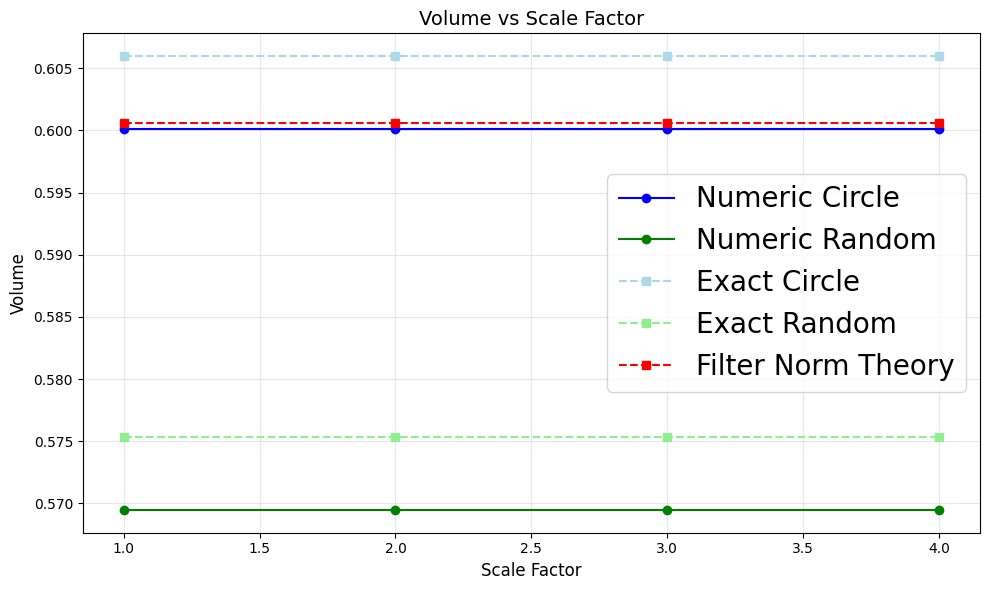

In [11]:
# Compute all volumes using all available samples (k = len(volume))
vol_circle, vol_random, vol_circle_exact, vol_random_exact = compute_all_volumes(
    circle_r_array, 
    random_r_array, 
    exact_circle_r_array, 
    exact_random_r_array, 
    k=len(random_r_array[0]),  # Using full sample size
    dimension=2
)

theoretical_volume = analytic_volume(a, w)
filter_theory_volume = theoretical_volume/a

# Create the plot
plt.figure(figsize=(10, 6))

# Plot numeric results
plt.plot(scale_factors, vol_circle, 'o-', label='Numeric Circle', color='blue')
plt.plot(scale_factors, vol_random, 'o-', label='Numeric Random', color='green')

# Plot exact results
plt.plot(scale_factors, vol_circle_exact, 's--', label='Exact Circle', color='lightblue')
plt.plot(scale_factors, vol_random_exact, 's--', label='Exact Random', color='lightgreen')

plt.plot(scale_factors, np.ones(len(scale_factors))*filter_theory_volume/np.pi, 's--', label='Filter Norm Theory', color='red')

# Add plot decorations
plt.xlabel('Scale Factor', fontsize=12)
plt.ylabel('Volume', fontsize=12)
plt.title('Volume vs Scale Factor', fontsize=14)
plt.legend(fontsize=20)
plt.grid(True, alpha=0.3)
#plt.ylim(0, 1.2*theoretical_volume/np.pi)

# Show plot
plt.tight_layout()
plt.savefig(f"experiments/a_{a}_w_{w}_n_perturb_{num_perturb_directions}/Volume_Scale.png")
plt.show()